### Project 5th With Sampled Data

Project ini adalah eksperimen tambahan sesuai dengan masukan dan saran dari ketua penguji seminar hasil, dimana data dilakukan sampling terlebih dahulu menjadi 700x700 kemudian di augmentasi untuk mengetahui perbedaannya

### Import Library

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import cv2
import shutil
import random

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten, Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from keras.models import Model
from keras.activations import relu
from keras.backend import softmax
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split

### Image Data Generator

In [1]:
train_path = '/Calvino/TA/models/5th_sampling/new_data/train'
valid_path = '/Calvino/TA/models/5th_sampling/new_data/val'
test_path = '/Calvino/TA/models/5th_sampling/new_data/test'
aug_path = '/Calvino/TA/models/5th_sampling/new_data/augmented_train'

In [5]:
image_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255 # Normalize pixel values to [0, 1]
)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = datagen.flow_from_directory(
    valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

aug_generator = datagen.flow_from_directory(
    aug_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 2100 images belonging to 5 classes.


Found 700 images belonging to 5 classes.
Found 700 images belonging to 5 classes.
Found 10500 images belonging to 5 classes.


### Development Phase

In [6]:
input_shape = train_generator.image_shape

lr = 0.0001
steps_per_epoch = 50
epochs = 30
validation_steps = 30

In [7]:
def show_accuracy(history, model, reg):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model + ' ' + reg + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def show_loss(history, model, reg):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model + ' ' + reg + ' Loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

#### ResNet-50

In [10]:
def residual_block(X_start, filters, name, reduce=False, res_conv2d=False):
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]

    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)

    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start

    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

# default (input_shape=[224, 224, 3]
def ResNet50(input_shape=(224,224,3)):
    assert len(input_shape) == 3

    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = residual_block(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_f')

    # conv5_x
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=5, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

In [11]:
model_ResNet50 = ResNet50()
model_ResNet50.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=lr),
                metrics=['accuracy'])

In [17]:
history_rn = model_ResNet50.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 730s 15s/step - loss: 1.9758 - accuracy: 0.2013 - val_loss: 1.6309 - val_accuracy: 0.1917
Epoch 2/30
50/50 [==============================] - 468s 9s/step - loss: 1.8110 - accuracy: 0.2373 - val_loss: 1.7241 - val_accuracy: 0.1937
Epoch 3/30
50/50 [==============================] - 219s 4s/step - loss: 1.8064 - accuracy: 0.2125 - val_loss: 1.8137 - val_accuracy: 0.2125
Epoch 4/30
50/50 [==============================] - 220s 4s/step - loss: 1.7766 - accuracy: 0.2463 - val_loss: 1.8532 - val_accuracy: 0.2042
Epoch 5/30
50/50 [==============================] - 253s 5s/step - loss: 1.7216 - accuracy: 0.2398 - val_loss: 1.9134 - val_accuracy: 0.1875
Epoch 6/30
50/50 [==============================] - 227s 4s/step - loss: 1.7017 - accuracy: 0.2322 - val_loss: 1.8827 - val_accuracy: 0.1688
Epoch 7/30
50/50 [==============================] - 228s 5s/step - loss: 1.7250 - accuracy: 0.2313 - val_loss: 2.0636 - val_accuracy: 0.1896
Epoch 8/30
5

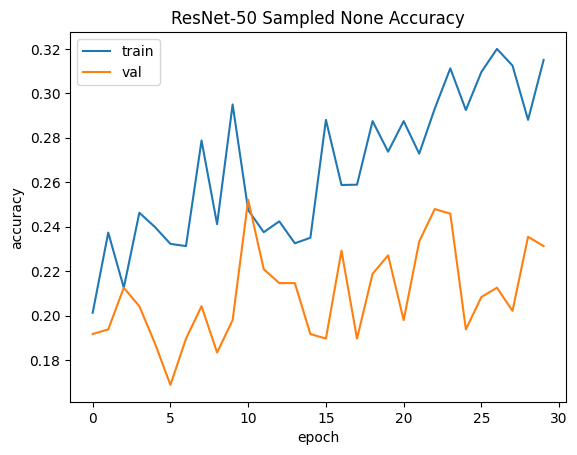

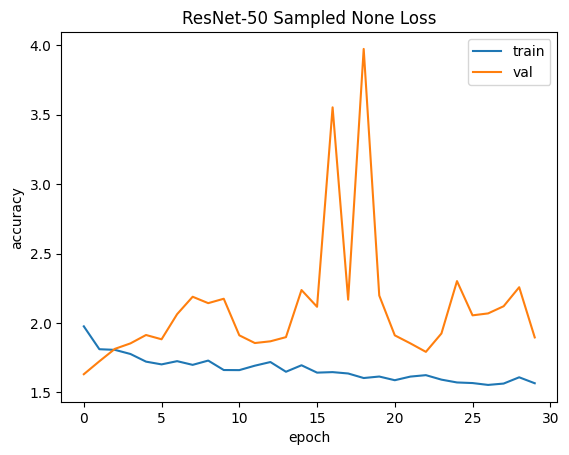

In [25]:
show_accuracy(history_rn, "ResNet-50", "Sampled None")
show_loss(history_rn, "ResNet-50", "Sampled None")

In [24]:
rn_loss, rn_acc = history_rn.model.evaluate(train_generator)
print(rn_loss)
print(rn_acc)

132/132 [==============================] - 138s 1s/step - loss: 1.6967 - accuracy: 0.2776
1.6966938972473145
0.27761903405189514


In [23]:
rn_loss, rn_acc = history_rn.model.evaluate(test_generator)
print(rn_loss)
print(rn_acc)

44/44 [==============================] - 27s 618ms/step - loss: 1.8429 - accuracy: 0.2243
1.8429200649261475
0.22428570687770844


In [20]:
y_pred = history_rn.model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cr = classification_report(y_true, y_pred_class)
print(cr)

44/44 [==============================] - 64s 1s/step
              precision    recall  f1-score   support

           0       0.20      0.71      0.31       138
           1       0.17      0.07      0.10       138
           2       0.20      0.16      0.18       167
           3       0.27      0.02      0.04       137
           4       0.00      0.00      0.00       120

    accuracy                           0.20       700
   macro avg       0.17      0.19      0.13       700
weighted avg       0.17      0.20      0.13       700



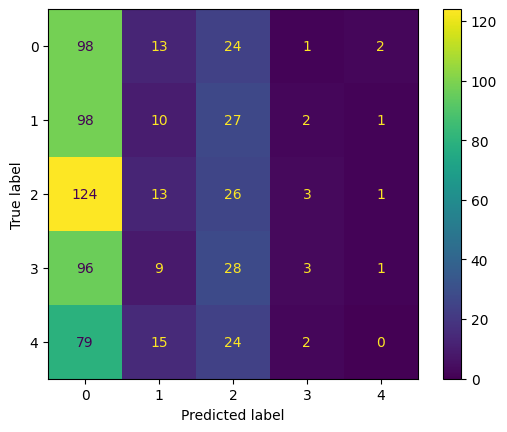

In [21]:
cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()

#### ResNet-50 w/ Aug

In [12]:
history_rn_aug = model_ResNet50.fit(
      aug_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = valid_generator,
      validation_steps = validation_steps,
      verbose=1)

Epoch 1/30
50/50 [==============================] - 686s 14s/step - loss: 1.9713 - accuracy: 0.1975 - val_loss: 1.6729 - val_accuracy: 0.1979
Epoch 2/30
50/50 [==============================] - 738s 15s/step - loss: 1.7644 - accuracy: 0.2313 - val_loss: 1.6461 - val_accuracy: 0.2208
Epoch 3/30
50/50 [==============================] - 720s 14s/step - loss: 1.8088 - accuracy: 0.2087 - val_loss: 1.7444 - val_accuracy: 0.2104
Epoch 4/30
50/50 [==============================] - 772s 15s/step - loss: 1.7832 - accuracy: 0.1887 - val_loss: 1.8034 - val_accuracy: 0.1979
Epoch 5/30
50/50 [==============================] - 480s 10s/step - loss: 1.7247 - accuracy: 0.2163 - val_loss: 1.7095 - val_accuracy: 0.2167
Epoch 6/30
50/50 [==============================] - 178s 4s/step - loss: 1.7446 - accuracy: 0.1988 - val_loss: 1.8085 - val_accuracy: 0.1917
Epoch 7/30
50/50 [==============================] - 192s 4s/step - loss: 1.7278 - accuracy: 0.2013 - val_loss: 1.8741 - val_accuracy: 0.1958
Epoch 8/

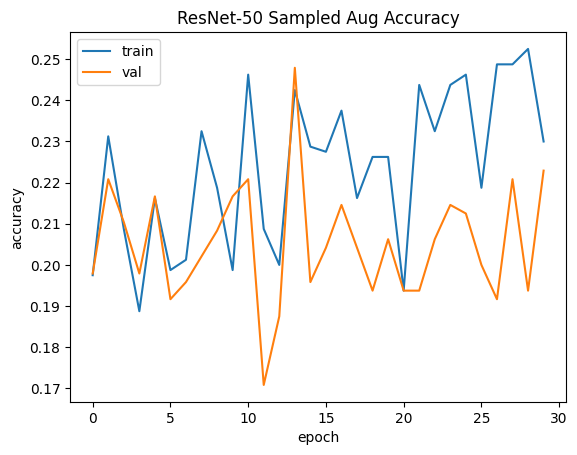

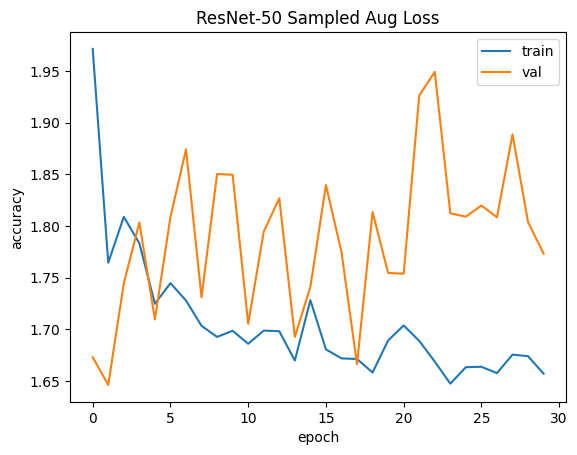

In [13]:
show_accuracy(history_rn_aug, "ResNet-50", "Sampled Aug")
show_loss(history_rn_aug, "ResNet-50", "Sampled Aug")

In [15]:
rn_loss, rn_acc = history_rn_aug.model.evaluate(aug_generator)
print(rn_loss)
print(rn_acc)

657/657 [==============================] - 2843s 4s/step - loss: 1.8346 - accuracy: 0.2162
1.834566593170166
0.21619047224521637


In [16]:
rn_loss, rn_acc = history_rn_aug.model.evaluate(test_generator)
print(rn_loss)
print(rn_acc)

44/44 [==============================] - 209s 5s/step - loss: 1.8059 - accuracy: 0.2257
1.8058648109436035
0.2257142812013626


In [17]:
y_pred = history_rn_aug.model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cr = classification_report(y_true, y_pred_class)
print(cr)

44/44 [==============================] - 198s 4s/step
              precision    recall  f1-score   support

           0       0.23      0.31      0.27       138
           1       0.00      0.00      0.00       138
           2       0.00      0.00      0.00       167
           3       0.21      0.74      0.32       137
           4       0.25      0.03      0.06       120

    accuracy                           0.21       700
   macro avg       0.14      0.22      0.13       700
weighted avg       0.13      0.21      0.13       700



c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kursge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

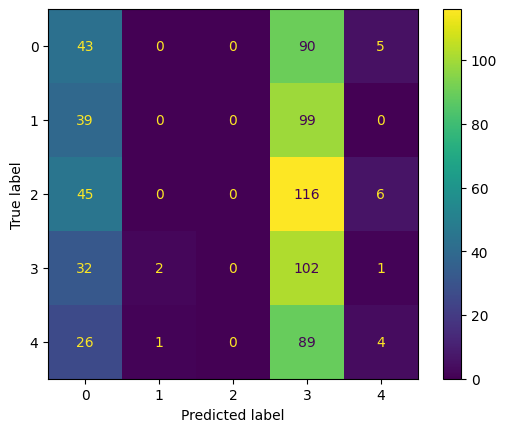

In [18]:
cm = confusion_matrix(y_true, y_pred_class)
cm_display = ConfusionMatrixDisplay(cm)

cm_display.plot()
plt.show()